In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import glob

In [2]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
mask = cv2.imread("Crops/Mask_Right_Bot.png")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = torch.Tensor(mask)
mask = mask / mask.max()

In [4]:
lambda_crop = torchvision.transforms.Lambda(lambda x: x[:,420:,183:235])
lambda_mask = torchvision.transforms.Lambda(lambda x: x * mask)

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(224)
])

In [6]:
dataset = torchvision.datasets.ImageFolder("Pruebas_Delay", transform=transform)

In [7]:
classes = dataset.classes
classes

['down', 'none', 'right']

In [8]:
train_split = 0.7
train_length = int(len(dataset)*train_split)
test_length = int(len(dataset)) - int(len(dataset)*train_split)

train, test = torch.utils.data.random_split(dataset, [train_length, test_length], generator = torch.Generator().manual_seed(42))
len(train), len(test)

(620, 267)

In [9]:
BATCH_SIZE = 16
trainloader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
testloader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)

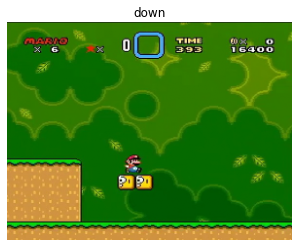

torch.Size([3, 224, 293])


In [10]:
for img, label in dataset:
    test = img
    plt.imshow(img.permute(1,2,0))
    plt.title(f"{classes[label]}")
    plt.axis('off')
    plt.show()
    print(test.shape)
    break

In [11]:
model = nn.Sequential(*[
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1, stride = 1),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1, stride = 2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1, stride = 2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1, stride = 2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(132608, 3)
])

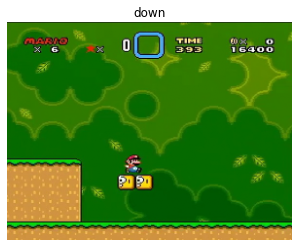

torch.Size([3, 224, 293])
torch.Size([1, 3])


In [12]:
for img, label in dataset:
    test = img
    plt.imshow(img.permute(1,2,0))
    plt.title(f"{classes[label]}")
    plt.axis('off')
    plt.show()
    print(test.shape)
    with torch.no_grad():
        pred = model(torch.unsqueeze(img,0))
    print(pred.shape)
    break

In [13]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [14]:
def accuracy_score(y_true, y_pred):
    y_pred = torch.softmax(y_pred, axis = 1).argmax(axis = 1)
    return torch.where(y_true == y_pred, 1, 0).sum() / len(y_pred)

In [15]:
EPOCHS = 20

losses = []
losses_test = []
accuracies = []
accuracies_test = []

for epoch in range(EPOCHS):

    loss_epoch = 0
    loss_epoch_test = 0
    accuracy_epoch = []
    accuracy_epoch_test = []

    for X, Y in trainloader:
        X, Y = X.to(device), Y.to(device)

        optimizer.zero_grad()

        pred = model(X)
        loss = loss_fn(pred, Y)

        loss.backward()
        optimizer.step()

        loss_epoch += loss
        accuracy_epoch.append(accuracy_score(Y, pred).item()) #Con item nos metemos el número sin tensor ni nada
    
    losses.append(loss_epoch)
    accuracies.append(np.mean(accuracy_epoch))

    for X_test, Y_test in testloader:
        X_test, Y_test = X_test.to(device), Y_test.to(device)

        with torch.no_grad():
            pred_test = model(X_test)
            loss_test = loss_fn(pred_test, Y_test)

        loss_epoch_test += loss_test
        accuracy_epoch_test.append(accuracy_score(Y_test, pred_test).item())

    losses_test.append(loss_epoch_test)
    accuracies_test.append(np.mean(accuracy_epoch_test))

    print(f"Época {epoch+1} --> Train: (MSE) {losses[-1]:.5f} (Accuracy): {accuracies[-1]:.5f} | Test: (MSE) {losses_test[-1]:.5f} (Accuracy): {accuracies_test[-1]:.5f}")

Época 1 --> Train: (MSE) 31.41921 (Accuracy): 0.66613 | Test: (MSE) 12.69009 (Accuracy): 0.69151
Época 2 --> Train: (MSE) 29.69722 (Accuracy): 0.68803 | Test: (MSE) 11.23397 (Accuracy): 0.68817
Época 3 --> Train: (MSE) 24.89147 (Accuracy): 0.70726 | Test: (MSE) 9.67914 (Accuracy): 0.76303
Época 4 --> Train: (MSE) 19.73953 (Accuracy): 0.78152 | Test: (MSE) 9.26171 (Accuracy): 0.76537
Época 5 --> Train: (MSE) 12.79900 (Accuracy): 0.86859 | Test: (MSE) 8.53457 (Accuracy): 0.82587
Época 6 --> Train: (MSE) 9.43622 (Accuracy): 0.91400 | Test: (MSE) 8.90226 (Accuracy): 0.80214
Época 7 --> Train: (MSE) 7.77209 (Accuracy): 0.92415 | Test: (MSE) 8.01650 (Accuracy): 0.87500
Época 8 --> Train: (MSE) 3.57081 (Accuracy): 0.97596 | Test: (MSE) 8.06588 (Accuracy): 0.86965
Época 9 --> Train: (MSE) 3.02127 (Accuracy): 0.97917 | Test: (MSE) 6.58679 (Accuracy): 0.87734
Época 10 --> Train: (MSE) 2.11363 (Accuracy): 0.97756 | Test: (MSE) 6.86167 (Accuracy): 0.92279
Época 11 --> Train: (MSE) 1.04542 (Accurac

In [17]:
torch.save(model.state_dict(), "ModeloCustomEtiquetadoFrames_DELAY.pth")

# Función de etiquetado

In [83]:
def label(model, imageloader):
    """
    Usamos el modelo dado para etiquetar las imágenes. 
    Hay que pasarlas como un dataloder directamente.
    Devuelve una lista con las etiquetas correspondientes

    Args:
    model -> Modelo de Pytorch
    imageloader -> DataLoader con las imágenes que queremos etiquetar

    Return:
    Devuelve una lista con las etiquetas correspondientes
    """
    labels = np.array([])
    for X in imageloader:
        X = X.to(device)
        with torch.no_grad():
            #Sacamos la predicción
            pred = model(X)
        #A la predicción hay que hacerle la SoftMax para sacar la etiqueta
        labels_batch = torch.softmax(pred, axis = 1).argmax(axis = 1)
        labels = np.concatenate((labels,labels_batch.cpu().numpy()), axis = 0)
        labels_name = [classes[int(label)] for label in labels]
    return labels_name

# Prueba Dataset Video

In [54]:
class VideoFrames(torch.utils.data.Dataset):
    """
    Dataset que carga un vídeo y extrae los frames
    """
    def __init__(self, path, transform = None):
        """
        path --> Path del que cargar el vídeo
        """
        super(VideoFrames, self).__init__()
        
        self.path = path
        # self.images_path = glob.glob(f"{path}/*.jpg")  
        self.frames = self.extract_frames(self.path)
        # self.images = np.array([np.array(Image.open(image)) for image in self.images_path])
        self.transform = transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        images = self.frames[idx]
        if self.transform:
            images = self.transform(images)
        return images

    def extract_frames(self, path_to_video):    
        """Coge un vídeo y extrae todos sus frames"""
        frames = []
        vidcap = cv2.VideoCapture(path_to_video)
        success,image = vidcap.read()
        count = 0
        while success:
            #Detallito porque OpenCV las carga como BGR y las queremos en RGB por consistencia
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            frames.append(image)
            success,image = vidcap.read()
            count += 1
        print(f"Extracted {count} frames!")
        return np.array(frames)

In [88]:
prueba_video = VideoFrames("Crops/1-3.mp4", transform = transform)

Extracted 715 frames!


In [89]:
prueba_loader = torch.utils.data.DataLoader(prueba_video, batch_size = 32)

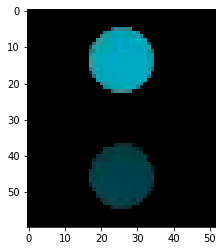

In [92]:
for frame in prueba_video:
    plt.imshow(frame.permute(1,2,0))
    plt.show()
    break

In [90]:
etiquetas = label(model, prueba_loader)

In [99]:
for i, (label, image) in enumerate(zip(etiquetas, prueba_video.frames)):
    cv2.imwrite(f"Frames/1-3/{label}/{i}.jpg", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# Transformaciones para coger la pantalla del juego a partir del frame

In [5]:
lambda_crop_game = torchvision.transforms.Lambda(lambda x: x[:,15:-20,265:])
lambda_mask = torchvision.transforms.Lambda(lambda x: x * mask)

In [147]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    lambda_crop_game,
])

In [148]:
prueba_video = VideoFrames("Crops/1-3.mp4", transform = transform)

Extracted 715 frames!


In [149]:
prueba_loader = torch.utils.data.DataLoader(prueba_video, batch_size = 32)

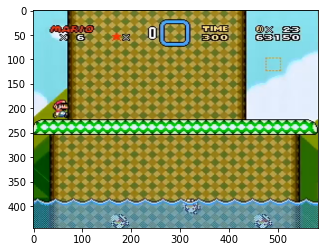

In [150]:
for frame in prueba_video:
    plt.imshow(frame.permute(1,2,0))
    plt.show()
    break

# Prueba modelo con frames del juego

In [6]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    lambda_crop_game,
    torchvision.transforms.Resize(224)
])

In [7]:
prueba = torchvision.datasets.ImageFolder("Frames/1-1/Full_Labeled", transform=transform)

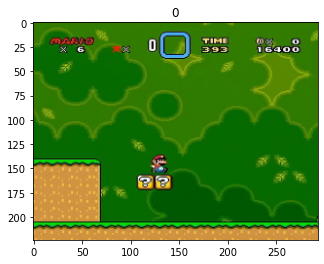

torch.Size([3, 224, 293])


In [8]:
for X, Y in prueba:
    plt.imshow(X.permute(1,2,0))
    plt.title(Y)
    plt.show()
    print(X.shape)
    break

In [9]:
train_split = 0.99
train_length = int(len(prueba)*train_split)
test_length = int(len(prueba)) - int(len(prueba)*train_split)

train, test = torch.utils.data.random_split(prueba, [train_length, test_length], generator = torch.Generator().manual_seed(42))
len(train), len(test)

(879, 9)

In [10]:
BATCH_SIZE = 32
trainloader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
testloader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)

In [168]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
#Freezeamos los parámetros del modelo
for a in model.parameters():
    a.requires_grad = False
#Cambiamos la capa FC que trae de serie por una con 3 salidas
model.fc = nn.Linear(in_features=512, out_features=3)

Using cache found in C:\Users\vila_/.cache\torch\hub\pytorch_vision_v0.6.0


In [17]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

NameError: name 'model' is not defined

In [14]:
def train_fn(model, optimizer, loss_fn, epochs, trainloader, testloader):    
    EPOCHS = epochs

    losses = []
    losses_test = []
    accuracies = []
    accuracies_test = []

    for epoch in range(EPOCHS):

        loss_epoch = 0
        loss_epoch_test = 0
        accuracy_epoch = []
        accuracy_epoch_test = []

        for X, Y in trainloader:
            X, Y = X.to(device), Y.to(device)

            optimizer.zero_grad()

            pred = model(X)
            loss = loss_fn(pred, Y)

            loss.backward()
            optimizer.step()

            loss_epoch += loss
            accuracy_epoch.append(accuracy_score(Y, pred).item()) #Con item nos metemos el número sin tensor ni nada
        
        losses.append(loss_epoch)
        accuracies.append(np.mean(accuracy_epoch))

        for X_test, Y_test in testloader:
            X_test, Y_test = X_test.to(device), Y_test.to(device)

            with torch.no_grad():
                pred_test = model(X_test)
                loss_test = loss_fn(pred_test, Y_test)

            loss_epoch_test += loss_test
            accuracy_epoch_test.append(accuracy_score(Y_test, pred_test).item())

        losses_test.append(loss_epoch_test)
        accuracies_test.append(np.mean(accuracy_epoch_test))

        print(f"Época {epoch+1} --> Train: (MSE) {losses[-1]:.5f} (Accuracy): {accuracies[-1]:.5f} | Test: (MSE) {losses_test[-1]:.5f} (Accuracy): {accuracies_test[-1]:.5f}")
    return losses, accuracies, losses_test, accuracies_test

In [173]:
EPOCHS = 20

losses = []
losses_test = []
accuracies = []
accuracies_test = []

for epoch in range(EPOCHS):

    loss_epoch = 0
    loss_epoch_test = 0
    accuracy_epoch = []
    accuracy_epoch_test = []

    for X, Y in trainloader:
        X, Y = X.to(device), Y.to(device)

        optimizer.zero_grad()

        pred = model(X)
        loss = loss_fn(pred, Y)

        loss.backward()
        optimizer.step()

        loss_epoch += loss
        accuracy_epoch.append(accuracy_score(Y, pred).item()) #Con item nos metemos el número sin tensor ni nada
    
    losses.append(loss_epoch)
    accuracies.append(np.mean(accuracy_epoch))

    for X_test, Y_test in testloader:
        X_test, Y_test = X_test.to(device), Y_test.to(device)

        with torch.no_grad():
            pred_test = model(X_test)
            loss_test = loss_fn(pred_test, Y_test)

        loss_epoch_test += loss_test
        accuracy_epoch_test.append(accuracy_score(Y_test, pred_test).item())

    losses_test.append(loss_epoch_test)
    accuracies_test.append(np.mean(accuracy_epoch_test))

    print(f"Época {epoch+1} --> Train: (MSE) {losses[-1]:.5f} (Accuracy): {accuracies[-1]:.5f} | Test: (MSE) {losses_test[-1]:.5f} (Accuracy): {accuracies_test[-1]:.5f}")

Época 1 --> Train: (MSE) 7.46396 (Accuracy): 0.85039 | Test: (MSE) 3.06097 (Accuracy): 0.87248
Época 2 --> Train: (MSE) 7.03505 (Accuracy): 0.82852 | Test: (MSE) 2.69747 (Accuracy): 0.86879
Época 3 --> Train: (MSE) 6.25318 (Accuracy): 0.87891 | Test: (MSE) 3.02515 (Accuracy): 0.84841
Época 4 --> Train: (MSE) 6.48832 (Accuracy): 0.86289 | Test: (MSE) 2.57492 (Accuracy): 0.85016
Época 5 --> Train: (MSE) 5.42035 (Accuracy): 0.91211 | Test: (MSE) 2.54793 (Accuracy): 0.88043


In [18]:
model_custom = nn.Sequential(*[
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1, stride = 1),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1, stride = 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1, stride = 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1, stride = 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(129024, 3)
])

In [19]:
model_custom.to(device)
optimizer = torch.optim.Adam(model_custom.parameters())
loss_fn = nn.CrossEntropyLoss()

In [20]:
loss_custom, accuracy_custom, loss_test_custom, accuracy_test_custom = train_fn(model_custom, optimizer, loss_fn, 35, trainloader, testloader)

RuntimeError: CUDA error: an illegal memory access was encountered

In [ ]:
torch.save(model_custom.state_dict(), "ModeloCustomFramesJuego_1-1-2.pth")

In [206]:
import time

In [207]:
for X, Y in prueba:
    X = X.to(device)
    with torch.no_grad():
        time_i = time.time()
        pred = model_custom(torch.unsqueeze(X,dim=0))
print(time.time()-time_i)

0.0010001659393310547
